In [3]:
%pylab
%matplotlib inline

import scipy as sp
import sounddevice
import librosa

from scipy import stats

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [73]:
def separate_hp(arr, fs):
    nperseg = int(0.03*fs)
    noverlap = int(0.01*fs)
    h_win = 100
    p_win = 100
    _, _, s = sp.signal.stft(arr, nperseg=nperseg, noverlap=noverlap)
    
    h_mask = sp.ndimage.median_filter(abs(s), (1, h_win))
    p_mask = sp.ndimage.median_filter(abs(s), (p_win, 1))
    
    h = np.where(h_mask > p_mask, s, 10e-5)
    p = np.where(p_mask > h_mask, s, 10e-5)
    
    _, ih = sp.signal.istft(h, nperseg=nperseg, noverlap=noverlap)
    _, ip = sp.signal.istft(p, nperseg=nperseg, noverlap=noverlap)
    
    return ih, ip

In [4]:
%store -r song_data
song, fs = song_data

In [5]:
a = song[1000000:1100000]

In [83]:
L = 10000
K = 10000
x = abs(a)

R = lambda n, k: np.sum(x[n:n+L-1]*x[n+k:n+k+L-1])

In [61]:
Kmin = int(fs/4.5)
Kmax = int(fs/0.5)
Rmat = np.array([R(100, j) for j in range(Kmin, Kmax)])

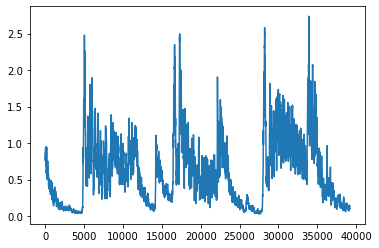

In [62]:
plt.plot(Rmat)

In [47]:
def median_smoothing(arr, n):
    med_x = np.median(arr)
    med_dev = stats.median_abs_deviation(arr)
    x = np.concatenate((med_x*np.ones(n//2), arr, med_x*np.ones(n//2)))
    x_win = np.lib.stride_tricks.sliding_window_view(x, n)
    meds = np.mean(x_win, axis=1) + med_dev
    
    return np.where(arr > meds[:-1], arr, 0)

In [63]:
med = median_smoothing(Rmat, 1000)

([<matplotlib.axis.XTick at 0x282d9d7fdf0>,
 [Text(0.0, 0, '270'),
  Text(5600.0, 0, '126'),
  Text(11200.0, 0, '82'),
  Text(16800.0, 0, '60'),
  Text(22400.0, 0, '48'),
  Text(28000.0, 0, '40'),
  Text(33600.0, 0, '34'),
  Text(39200.0, 0, '30')])

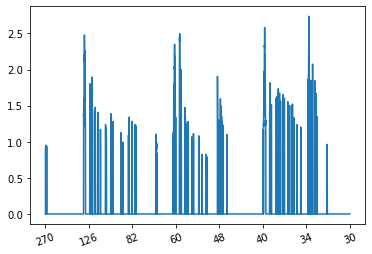

In [81]:
plt.plot(med)
plt.xticks(np.linspace(0, len(med), 8), 60*fs//np.linspace(Kmin, Kmax, 8, dtype=int), rotation=20)

In [74]:
h, p = separate_hp(song, fs)

In [84]:
x = abs(p[1000000:1100000])
r = np.array([R(100, j) for j in range(Kmin, Kmax)])

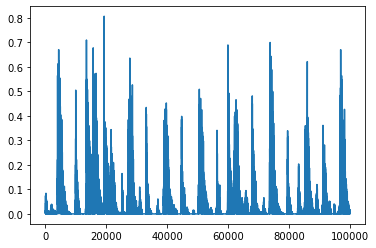

In [79]:
plt.plot(x)

([<matplotlib.axis.XTick at 0x282dc4ff970>,
 [Text(0.0, 0, '270'),
  Text(5600.0, 0, '126'),
  Text(11200.0, 0, '82'),
  Text(16800.0, 0, '60'),
  Text(22400.0, 0, '48'),
  Text(28000.0, 0, '40'),
  Text(33600.0, 0, '34'),
  Text(39200.0, 0, '30')])

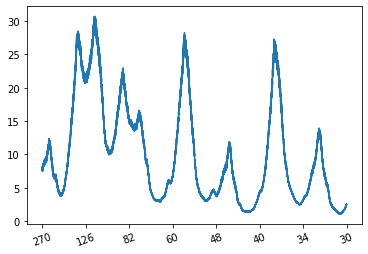

In [85]:
plt.plot(r)
plt.xticks(np.linspace(0, len(med), 8), 60*fs//np.linspace(Kmin, Kmax, 8, dtype=int), rotation=20)

In [86]:
rmed = median_smoothing(r, 10000)

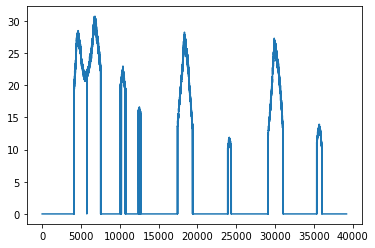

In [87]:
plt.plot(rmed)

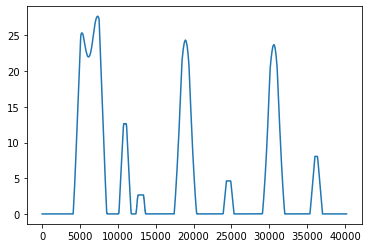

In [105]:
plt.plot(np.convolve(rmed, np.ones(1000)/1000))

In [109]:
peaks = np.where(rmed)[0]
carr = np.array([peaks[i] for i in range(len(peaks)) if (peaks[i] == 0) or (i != 0 and (peaks[i]-peaks[i-1] > 10))])

In [96]:
def remove_gradients(arr):
    grad = arr[1:] - arr[:-1]
    mask = np.concatenate(([0], (grad[:-1] >= 0) & (grad[1:] <= 0), [0]))
    
    return np.where(mask, arr, 0)

In [112]:
60 * fs / (carr + Kmin)

array([147.03267393, 106.00961538,  88.41809798,  88.34134615,
        88.2       ,  76.5447813 ,  75.55682467,  75.35026768,
        75.30309067,  75.2559727 ,  59.26888272,  59.23173352,
        54.39072521,  45.95824504,  38.9495687 ,  32.86956522,
        32.84834641])

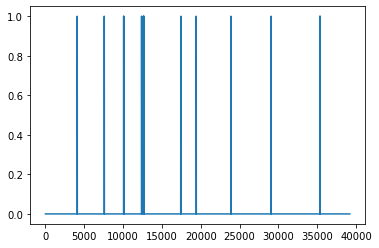

In [113]:
pks = np.zeros(len(rmed))
pks[carr] = 1
plt.plot(pks)

In [131]:
def find_max(arr, n):
    arr = np.concatenate((np.zeros(int(n/2)), np.copy(arr), np.zeros(int(n/2))))
    for i in range(int(n/2), len(arr)-int(n/2)):
        if int(n/2)+1 != np.argmax(arr[i-int(n/2):i+int(n/2)]):
            arr[i] = 0
            
    return arr[int(n/2):-int(n/2)]

In [134]:
rmax = find_max(r, 10000)
rmax.shape, r.shape

((39200,), (39200,))

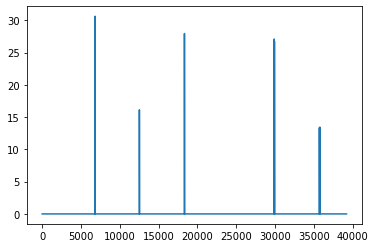

In [135]:
plt.plot(rmax)

In [138]:
bps = 60 * fs / (np.where(rmax)[0] + Kmin)

In [139]:
bps[0] / bps

array([1.        , 1.4882966 , 1.98402529, 2.97198018, 2.97420126,
       3.46839228, 3.473347  ])

In [8]:
def mod_short_time_autocorr(arr, window_length, lag_min, lag_max):
    return np.array([np.sum(arr[:window_length-1]*arr[k:k+window_length-1]) for k in range(lag_min, lag_max)])

In [2]:
def tempo_short_time_autocorr(arr, fs):
    return mod_short_time_autocorr(abs(arr), window_length=10000, lag_min=int(fs/4.5), lag_max=int(fs/0.5))

In [15]:
rxx = mod_short_time_autocorr(abs(a), int(0.03*fs), 0, len(a)-int(0.03*fs))

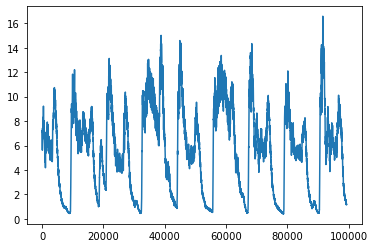

In [17]:
plot(abs(rxx))